## Intro
I've chosen Animals-10 dataset for classification. As I'm working locally, it's extracted into a local `data` directory.

Here's also a link to the [repository](https://github.com/rchuk/uni_cv_classification).

In [3]:
import matplotlib.pyplot as plt

# Dataset

## Dataset loading #1

In [4]:
import os
import os.path as path

We can see that dataset contains `raw-img` folder with subfolder of 10 classes of animals. Each class consists of a large list of images.

There's also `translate.py` file, because folders are named in italian(?) for some reason. Maybe I should've cleaned up the dataset, by renaming the directories and writing code for downloading and extracting the dataset, but we'll keep it simple for now and use the provided file. Also it turned out the for some reason, the translation for spider was missing, so I added forked version to the git.

In [5]:
import data.translate as dataset_translate

base_dataset_path = "./data"
dataset_path = path.join(base_dataset_path, "raw-img")

def get_class_name(folder_name: str) -> str:
    return dataset_translate.translate.get(folder_name)
    
classes = sorted(os.listdir(dataset_path))
print("Classes:", list(map(get_class_name, classes)))
class_count = len(classes)
print("Class count:", class_count)
by_class_count = {get_class_name(cls): len(os.listdir(path.join(dataset_path, cls))) for cls in classes}
print("Image count by class:", by_class_count)

Classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Class count: 10
Image count by class: {'dog': 4863, 'horse': 2623, 'elephant': 1446, 'butterfly': 2112, 'chicken': 3098, 'cat': 1668, 'cow': 1866, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


For the next step, that requires us to load data and convert it into tensors, I'd like to know the resolution of the images in the dataset.

I'm afraid that if I were to select some low resolution like 128x128, I might lose a lot of details and get worse quality model.

In [6]:
from torchvision.io import read_image
from collections import Counter

resolutions = []
for root, _, files in os.walk(dataset_path):
    images = filter(lambda file: file.lower().endswith((".png", ".jpg", ".jpeg")), files)
    paths = map(lambda file: os.path.join(root, file), images)
    for img_path in paths:
        try:
            img = read_image(img_path)
            height, width = img.shape[1], img.shape[2]
            resolutions.append((width, height))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

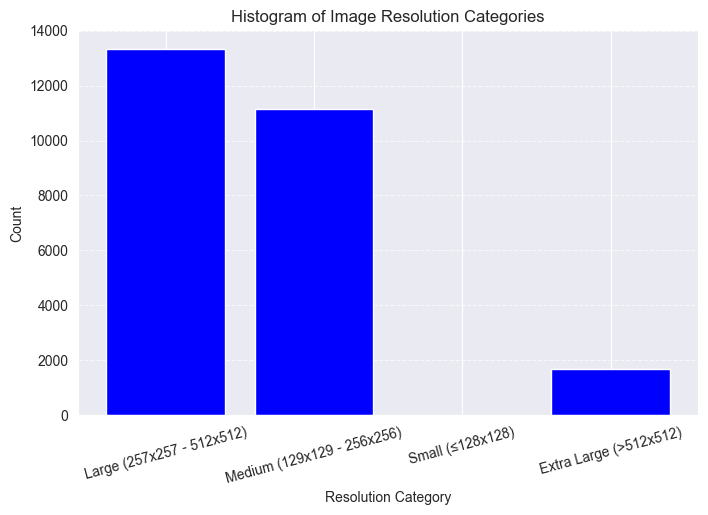

In [7]:
def categorize_resolution(width: int, height: int) -> str:
    area = width * height
    if area <= 128 * 128:
        return "Small (≤128x128)"
    elif area <= 256 * 256:
        return "Medium (129x129 - 256x256)"
    elif area <= 512 * 512:
        return "Large (257x257 - 512x512)"
    else:
        return "Extra Large (>512x512)"

resolution_categories = map(lambda x: categorize_resolution(x[0], x[1]), resolutions)
category_counts = Counter(resolution_categories)

plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color="blue")
plt.xlabel("Resolution Category")
plt.ylabel("Count")
plt.title("Histogram of Image Resolution Categories")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

So we can see that images have quite large resolution, more than 128x128 (by pixel count). But that doesn't provide us with all required information. I'd also like to know the aspect ratio of the images.

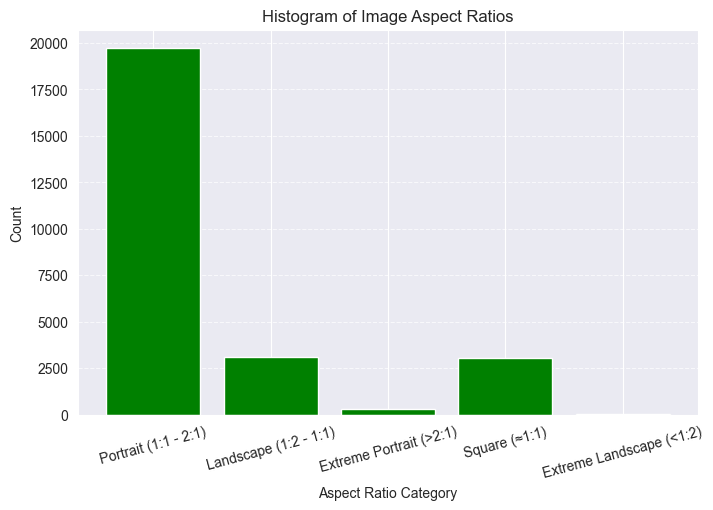

In [8]:
def categorize_aspect_ratio(width: int, height: int) -> str:
    ratio = width / height
    if 0.9 <= ratio <= 1.1:
        return "Square (≈1:1)"
    elif 1.1 < ratio <= 2:
        return "Portrait (1:1 - 2:1)"
    elif 0.5 <= ratio < 0.9:
        return "Landscape (1:2 - 1:1)"
    elif ratio > 2:
        return "Extreme Portrait (>2:1)"
    else:
        return "Extreme Landscape (<1:2)"

aspect_ratio_categories = map(lambda x: categorize_aspect_ratio(x[0], x[1]), resolutions)
aspect_ratio_counts = Counter(aspect_ratio_categories)

plt.figure(figsize=(8, 5))
plt.bar(aspect_ratio_counts.keys(), aspect_ratio_counts.values(), color="green")
plt.xlabel("Aspect Ratio Category")
plt.ylabel("Count")
plt.title("Histogram of Image Aspect Ratios")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Okay, so there are *a lot* more portrait images than anything else. There are also quite a few square images and approximately the same quantity of landscape ones.

## Dataset loading #2

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

I've set resolution to 128x128 as small details shouldn't matter much, but the training speed greatly increased, which would allow for a larger model. I expect it to give better results

In [10]:
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, images_to_remove=None):
        super().__init__(root, transform)
        if images_to_remove is None:
            images_to_remove = set()
        images_to_remove = set(map(lambda x: os.path.normpath(x), images_to_remove))
        self.samples = [(path, label) for path, label in self.samples if os.path.relpath(path, root) not in images_to_remove]
        self.imgs = self.samples

In [11]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(128, scale=(0.8, 1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_val_transform = transforms.Compose([
    transforms.Resize((128, 128)), #
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Only for the purposes of the course
# Otherwise I would just delete them manually from the filesystem
dataset = FilteredImageFolder(root=dataset_path, images_to_remove={
    "cane/OIP-_fFULVvrJ1pzZ5opnNfLMAHaFo.jpeg",
    "cane/OIP-_wnleOh6KMc2kur5ek1BuAHaFh.jpeg",
    "cane/OIP-6jzX7gx2yu6z1I-UZcHnGAAAAA.jpeg",
    "cane/OIP-6XZo5Xtu-krMjGU7kqe3HAHaEK.jpeg",
    "cavallo/OIP-9Q7OOSZYxEWnnleuRXvtNAHaEK.jpeg",
    "cavallo/OIP-36BCYm7wnJN6KvDHTTDrOAHaFj.jpeg",
    "cavallo/OIP-96nHrpFGuUGnWvpy9GLjHQHaLH.jpeg",
    "elefante/e837b90a29fd083ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd.jpeg",
    "elefante/ea37b40821f3013ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg",
    "elefante/OIP-2ruOSDIBcVIAMULdO9DDgAHaK3.jpeg",
    "elefante/OIP-3k_ZBVOd3Ozz6vh1fVHFGAHaEK.jpeg",
    "elefante/OIP-75pmfkEuZ6XUYXX2ZdnvhgHaE9.jpeg",
    "gatto/781.jpeg",
    "gatto/907.jpeg",
    "gatto/922.jpeg",
    "gatto/934.jpeg",
    "gatto/946.jpeg",
    "mucca/OIP-Clk22EfdRb623jSiUv3E6wHaEc.jpeg",
    "mucca/OIP-CM9VdkmMdx7T7gYxmDzIjgHaEK.jpeg",
    "pecora/ea34b80629f5013ed1584d05fb1d4e9fe777ead218ac104497f5c978a6ebb3bf_640.jpg",
    "pecora/ea36b2092df1093ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg",
    "pecora/OIP-1kotlugHdiQBAhOZxK4SfgHaFj.jpeg",
    "pecora/OIP-2tog-wY_7FE1b7As05JqjAHaFj.jpeg",
    "ragno/e83cb40728f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb3b9_640.jpg",
    "ragno/ea3db80c2af51c22d2524518b7444f92e37fe5d404b0144390f8c47ba6ebb4_640.jpg",
    "ragno/ea35b10f29f1013ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg",
    "ragno/ea36b60f21f7003ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg",
    "ragno/eb3cb00c2ff2003ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg",
    "ragno/eb32b90d2af7083ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb3b9_640.jpg",
    "ragno/ef32b70c20e90021d85a5854ee454296eb70e3c818b413449df5c379a1e8_640.jpg",
    "ragno/OIP-_8wFwT3vtv2H_uOLAo6jNwHaE9.jpeg",
    "ragno/OIP-0PIIz78MuYqCPg8vmFmABQHaEs.jpeg",
    "ragno/OIP-1tLy-hhPESqaJ3-mrlqmJgHaGE.jpeg",
    "scoiattolo/OIP-_WyHKgREia-4VijlL6DNswHaFj.jpeg",
    "scoiattolo/OIP-906teyQFcjAOGto59Erb0AHaIZ.jpeg",
    "scoiattolo/OIP-a1HFPOOx8hCh4TtDk6ChFgHaGX.jpeg",
    "scoiattolo/OIP-D6BUkBN5wh_nkoheV7sVOgHaE5.jpeg",
    "scoiattolo/OIP-DlwICIPtlrWDrdz6v-QVCQHaFe.jpeg",
    "scoiattolo/OIP-DxpY3cgvlO_SvTDdsjjvzgHaFd.jpeg"
})
print("Dataset:", dataset)

Dataset: Dataset FilteredImageFolder
    Number of datapoints: 26141
    Root location: ./data\raw-img


Now we can explore dataset in more detail.

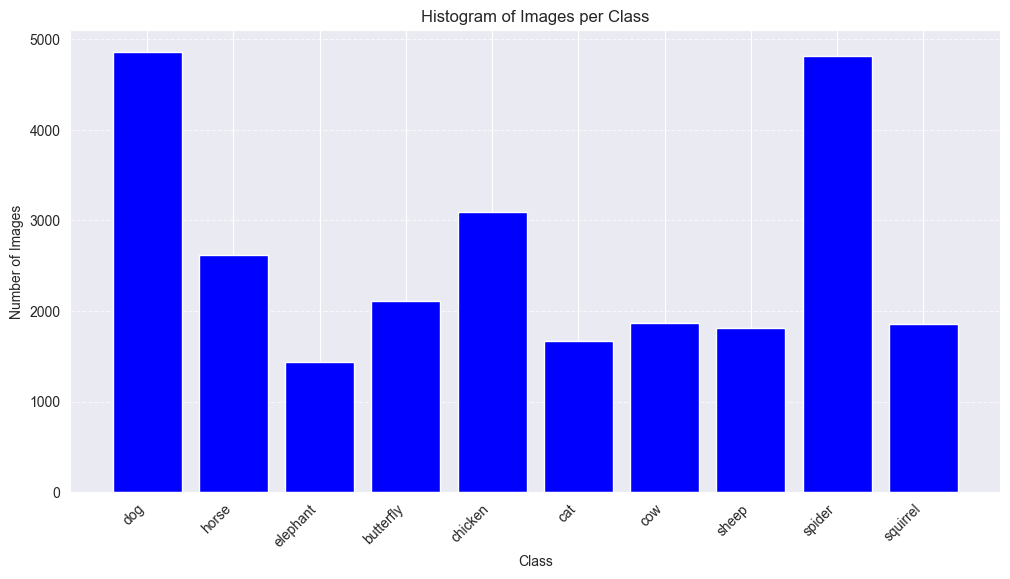

In [12]:
category_counts = Counter([get_class_name(dataset.classes[label]) for _, label in dataset.samples])

plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values(), color="blue")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Histogram of Images per Class")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Huh, there are a lot of spiders and dogs, other classes are much more balanced. Later this might present some problems with training, that should be addressed.

Surprisingly, there are also few cats. Is the author of the dataset a dog lover?

## Creating the data loaders

In [21]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

batch_size = 256
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
val_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=test_val_transform)
test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=test_val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 15684
Validation size: 5228
Test size: 5229


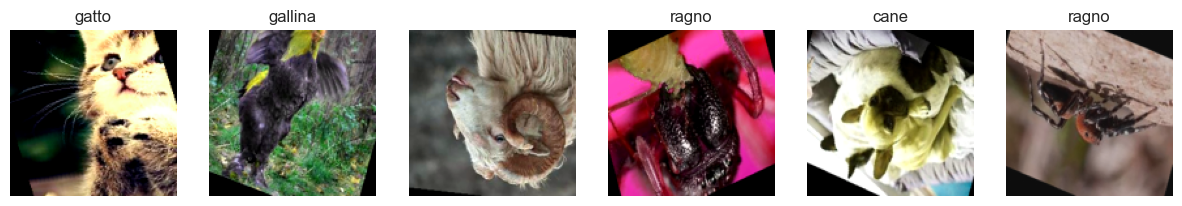

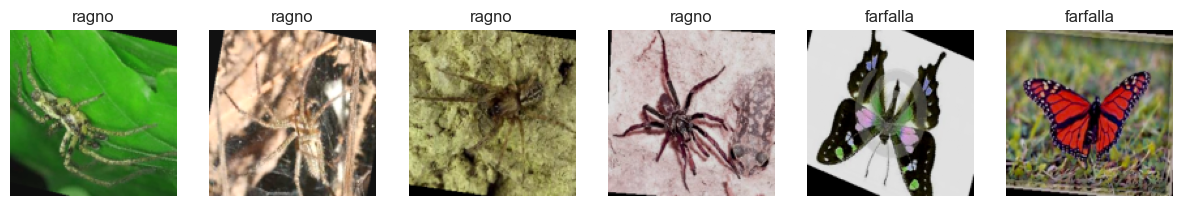

In [22]:
def show_images(dataloader, classes, num_images=6):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(get_class_name(classes[labels[i]]))
        axes[i].axis("off")

    plt.show()

show_images(train_loader, classes)
show_images(train_loader, classes)

Looks pretty good so far.

Except I randomly stumbled on an image of some cucumber with fried potato that was classified as a chicken. Then I lost the screenshot and went on to find it. But I found even more...

![Weird image #1](data/raw-img/gallina/OIP-dDF1mtC9R9xm9NOYkrZafQHaE8.jpeg)
![Weird image #2](data/raw-img/gallina/OIP-YvKka0TCIyNPGwVatOjxkwHaFj.jpeg)
![Weird image #3](data/raw-img/gallina/OIP-1z1sRkLnG5Csiq7yNhUn5gHaFz.jpeg)

That also might present some problems and would require a dataset cleanup.

So for the next step I need to think about the model architecture, optimizator and metrics. And that's exactly what I'll do.

# Model

I've experimented a lot. Here are key takeaways:
- My GPU was initially underutilized. Increasing batch size allowed to utilize all or almost all the VRAM, which should allow to complete the training faster.
- I've also added `pin_memory=True` to the data loaders, which should speed up the training
- I've removed augmentations from test and validation datasets, which were previously erroneously added
- I've decreased images resolution to 128x128 as small details shouldn't matter much, but the training speed greatly increased, which allowed for a larger model.
- I've manually cleaned up the dataset, as there were a bit of images which were either completely out of place, or incorrectly classified.
- I've added weights to the loss function, as some classes are represented more
- I've played with different layer count; added more augmentations; dropout to improve regularization, as the network seemed overfitting. Then I've also added batch normalization, which seemed to speed up the training.

There must be more things that I forgot to mention, but here is the final result (for now).

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


tensor([0.5318, 0.9895, 1.7863, 1.2292, 0.8343, 1.5622, 1.4207, 1.4658, 0.5484,
        1.4549], device='cuda:0')
Epoch 1/30, Train Loss: 2.0235, Train Acc: 0.2802, Val Loss: 1.9355, Val Acc: 0.3363
Epoch 2/30, Train Loss: 1.7324, Train Acc: 0.4003, Val Loss: 1.6165, Val Acc: 0.4526
Epoch 3/30, Train Loss: 1.5544, Train Acc: 0.4650, Val Loss: 1.4689, Val Acc: 0.4920
Epoch 4/30, Train Loss: 1.4253, Train Acc: 0.5150, Val Loss: 1.6061, Val Acc: 0.4426
Epoch 5/30, Train Loss: 1.3401, Train Acc: 0.5446, Val Loss: 1.5425, Val Acc: 0.4828
Epoch 6/30, Train Loss: 1.2698, Train Acc: 0.5677, Val Loss: 1.3985, Val Acc: 0.5025
Epoch 7/30, Train Loss: 1.1993, Train Acc: 0.5917, Val Loss: 1.1845, Val Acc: 0.6138
Epoch 8/30, Train Loss: 1.1789, Train Acc: 0.5984, Val Loss: 1.1871, Val Acc: 0.5509
Epoch 9/30, Train Loss: 1.1273, Train Acc: 0.6146, Val Loss: 1.1205, Val Acc: 0.6115
Epoch 10/30, Train Loss: 1.0780, Train Acc: 0.6299, Val Loss: 1.1912, Val Acc: 0.5803
Epoch 11/30, Train Loss: 1.0540, Tr

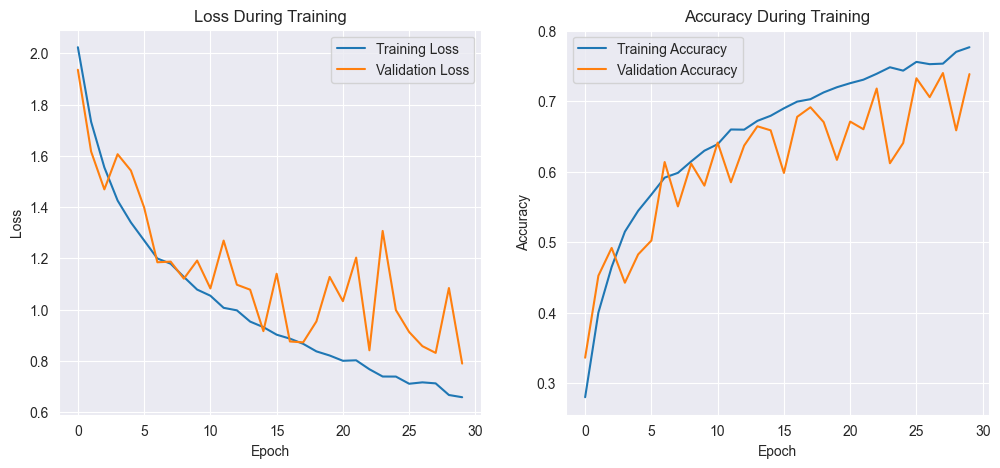

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))

        x = torch.flatten(x, 1)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(labels)
weights = torch.tensor(
    [sum(class_counts.values()) / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))],
    dtype=torch.float32
).to(device)

print(weights)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

num_epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss During Training")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy During Training")
 
plt.show()

torch.save(model.state_dict(), "model1.pth")

So these graphs definitely don't look ideal to me. Validation accuracy oscillation should be fixed, but that's what I've got for now.

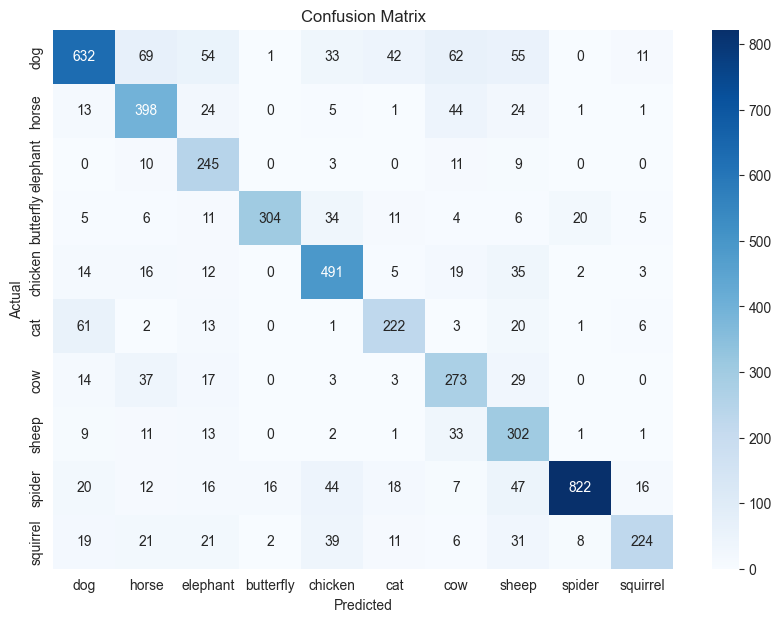

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, classes, device):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

classes = list(map(get_class_name, train_dataset.dataset.classes))
plot_confusion_matrix(model, test_loader, classes, device)

Here's also a confusion matrix, which helps us better understand the results.

In [32]:
import torch
from sklearn.metrics import f1_score

def compute_f1(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted")
    
    return f1

f1_val = compute_f1(model, val_loader, device)
print(f"Validation F1 Score: {f1_val:.4f}")

Validation F1 Score: 0.7439


And also F1 score, which should be a better metric than precision for our case,